## Feature Engineering 

## bu sayfada öğrenebilir psikolojik sinyalleri üretmek amacıyla oluşturulan yüksek boyutlu özellik uzayı üzerinde RandomForst _ GridSearchTV uygulanmiştir

Verilerdeki yüksek benzerlik problemini çözmeye yönelik bir girişim olarak ve her açıdan dengeli ve her açıdan hassas bir sistem kurmak amacıyla,

şu noktalara odaklanan bir yaklaşım benimsedik:

psikolojik sinyalin anlamı

öğrenilebilirliği

gerçekçi sınırları


Mevcut verilerden öğrenilebilir psikolojik sinyaller çıkarmaya çalıştık. Bu süreçte:

birden fazla psikolojik göstergenin tek bir temsilde birleştirilmesi

psikolojik faktörler arasındaki birikimi ve örtüşmeyi ifade eden bileşik özelliklerin oluşturulması

özellik uzayının büyük ölçüde genişletilmesi


adımları uygulandı.

Bundan sonra bu özellikleri istatistiksel olarak değerlendirmeye geçtik. Bu değerlendirme şu adımlar üzerinden yapıldı:

varyansların hesaplanması

hedef sütun ile olan ilişkinin incelenmesi

en anlamlı özellikleri seçmek için skorların (Scores) kullanılması


Bu işlemler, örnek sayısı büyük ve benzerlik düzeyi yüksek olan tüm veri seti üzerinde uygulandığında, süreç hesaplama açısından çok maliyetli hâle geldi.

Bu aşamaya ait son hücre, bir programlama hatası nedeniyle durmadı; aksine:

yüksek boyutlu bir özellik uzayının

yoğun istatistiksel işlemlerle

büyük ve birbirine yakın veriler üzerinde


birlikte kullanılması, nihai bir sonuç üretmeden çok uzun bir çalışma süresine yol açtı.

Buna bağlı olarak, bu yolun durdurulmasına bilinçli ve metodolojik bir karar verildi ve bu girişim, mevcut veriler kullanılarak psikolojik sinyallerden nelerin çıkarılabileceğinin sınırlarını gösteren başlı başına bir araştırma sonucu olarak kabul edildi.

Nihai sonuç olarak, sistemin ulaştığı performans sınırları modellerin veya metodolojinin zayıflığını değil, verinin kendi içinde barındırdığı bilgi sınırlarını yansıtmaktadır.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [2]:
df = pd.read_csv("depression_data.csv")

print(df.shape)
df.head()


(413768, 16)


,Name,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions
0,Christine Barker,31,Married,Bachelor's Degree,2,Non-smoker,Active,Unemployed,26265.67,Moderate,Moderate,Fair,Yes,No,Yes,Yes
1,Jacqueline Lewis,55,Married,High School,1,Non-smoker,Sedentary,Employed,42710.36,High,Unhealthy,Fair,Yes,No,No,Yes
2,Shannon Church,78,Widowed,Master's Degree,1,Non-smoker,Sedentary,Employed,125332.79,Low,Unhealthy,Good,No,No,Yes,No
3,Charles Jordan,58,Divorced,Master's Degree,3,Non-smoker,Moderate,Unemployed,9992.78,Moderate,Moderate,Poor,No,No,No,No
4,Michael Rich,18,Single,High School,0,Non-smoker,Sedentary,Unemployed,8595.08,Low,Moderate,Fair,Yes,No,Yes,Yes


In [3]:
target_col = "History of Mental Illness"
y = df[target_col].map({"Yes": 1, "No": 0})


In [4]:
numerical_cols = [
    "Age",
    "Number of Children",
    "Income"
]

categorical_cols = [
    "Marital Status",
    "Education Level",
    "Smoking Status",
    "Physical Activity Level",
    "Employment Status",
    "Alcohol Consumption",
    "Dietary Habits",
    "Sleep Patterns",
    "History of Substance Abuse",
    "Family History of Depression",
    "Chronic Medical Conditions"
]


In [5]:
df_fe = df[numerical_cols + categorical_cols].copy()


In [6]:
# Lifestyle interaction features
df_fe["Alcohol_Smoking"] = (
    df["Alcohol Consumption"].astype(str) + "_" +
    df["Smoking Status"].astype(str)
)

df_fe["Sleep_Activity"] = (
    df["Sleep Patterns"].astype(str) + "_" +
    df["Physical Activity Level"].astype(str)
)

# Economic stress proxy
df_fe["Income_per_Child"] = df["Income"] / (df["Number of Children"] + 1)

# Work-life stress
df_fe["Employment_Sleep"] = (
    df["Employment Status"].astype(str) + "_" +
    df["Sleep Patterns"].astype(str)
)


In [7]:
numerical_cols_extended = numerical_cols + ["Income_per_Child"]

categorical_cols_extended = categorical_cols + [
    "Alcohol_Smoking",
    "Sleep_Activity",
    "Employment_Sleep"
]


In [8]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_cols_extended),
        ("cat", categorical_transformer, categorical_cols_extended)
    ]
)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    df_fe,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_test.shape)


(331014, 18) (82754, 18)


In [10]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_train_transformed.shape


(331014, 60)

In [11]:
df_fe = df.copy()
print("Dataset copied for feature engineering")


Dataset copied for feature engineering


Depresyon kronolojik yaşla değil, yaşam evreleriyle ilişkilidir

In [12]:
# Age-based features
df_fe["Age_Group"] = pd.cut(
    df_fe["Age"],
    bins=[17, 25, 35, 45, 55, 65, 100],
    labels=["18-25", "26-35", "36-45", "46-55", "56-65", "65+"]
)

df_fe["Is_Young"] = (df_fe["Age"] < 30).astype(int)
df_fe["Is_Elder"] = (df_fe["Age"] > 55).astype(int)

df_fe[["Age", "Age_Group", "Is_Young", "Is_Elder"]].head()


,Age,Age_Group,Is_Young,Is_Elder
0,31,26-35,0,0
1,55,46-55,0,0
2,78,65+,0,1
3,58,56-65,0,1
4,18,18-25,1,0


Çocuklu bir gelir ≠ Sorumluluksuz bir gelir

In [13]:
# Income normalization & stress proxy
df_fe["Income_per_Child"] = df_fe["Income"] / (df_fe["Number of Children"] + 1)

df_fe["Low_Income"] = (df_fe["Income"] < df_fe["Income"].median()).astype(int)
df_fe["High_Income"] = (df_fe["Income"] > df_fe["Income"].quantile(0.75)).astype(int)

df_fe[["Income", "Number of Children", "Income_per_Child", "Low_Income"]].head()


,Income,Number of Children,Income_per_Child,Low_Income
0,26265.67,2,8755.223333,1
1,42710.36,1,21355.180000,0
2,125332.79,1,62666.395000,0
3,9992.78,3,2498.195000,1
4,8595.08,0,8595.080000,1


Uyku Modellerinin Kodlanması

In [14]:

sleep_map = {
    "Poor": 2,
    "Fair": 1.5,    
    "Average": 1,
    "Good": 0
}

df_fe["Sleep_Risk"] = df_fe["Sleep Patterns"].map(sleep_map).fillna(1) #
df_fe[["Sleep Patterns", "Sleep_Risk"]].head()

,Sleep Patterns,Sleep_Risk
0,Fair,1.5
1,Fair,1.5
2,Good,0.0
3,Poor,2.0
4,Fair,1.5


Fiziksel Aktivite

In [15]:
# 
activity_map = {
    "Sedentary": 2,   
    "Low": 1.5,
    "Moderate": 1,
    "Active": 0.5,    
    "High": 0
}

df_fe["Activity_Risk"] = df_fe["Physical Activity Level"].map(activity_map).fillna(1)
df_fe[["Physical Activity Level", "Activity_Risk"]].head()

,Physical Activity Level,Activity_Risk
0,Active,0.5
1,Sedentary,2.0
2,Sedentary,2.0
3,Moderate,1.0
4,Sedentary,2.0


Alkol ve Sigara Kullanımı (Riskli Davranışlar)

In [16]:
df_fe["Substance_Risk"] = (
    (df_fe["Smoking Status"] != "Non-smoker").astype(int) +
    (df_fe["Alcohol Consumption"] == "High").astype(int)
)

df_fe[["Smoking Status", "Alcohol Consumption", "Substance_Risk"]].head()


,Smoking Status,Alcohol Consumption,Substance_Risk
0,Non-smoker,Moderate,0
1,Non-smoker,High,1
2,Non-smoker,Low,0
3,Non-smoker,Moderate,0
4,Non-smoker,Low,0


Kümülatif Risk Özellikleri 🧠 Burada model için güçlü bir sinyal oluşturuyoruz."

Bileşik Psikolojik Risk Endeksi

In [17]:
df_fe["Psychological_Risk_Index"] = (
    df_fe["Sleep_Risk"].fillna(0) +
    df_fe["Activity_Risk"].fillna(0) +
    df_fe["Substance_Risk"].fillna(0) +
    df_fe["Low_Income"].fillna(0)
)

df_fe["Psychological_Risk_Index"].describe()


count    413768.000000
mean          3.818147
std           1.354723
min           0.500000
25%           3.000000
50%           4.000000
75%           5.000000
max           7.000000
Name: Psychological_Risk_Index, dtype: float64

Verilerin modelleme için yeniden hazırlanması 🟩 Hücre 8: X ve y'nin ayrılması (FE versiyonu)

In [18]:
TARGET = "History of Mental Illness"

y_fe = df_fe[TARGET].map({"No": 0, "Yes": 1})
X_fe = df_fe.drop(columns=[TARGET, "Name"])


FE sonrası sayısal ve kategorik sütunlar

In [19]:
num_cols_fe = X_fe.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols_fe = X_fe.select_dtypes(include=["object", "category"]).columns.tolist()

print("Numerical FE columns:", num_cols_fe)
print("Categorical FE columns:", cat_cols_fe)


Numerical FE columns: ['Age', 'Number of Children', 'Income', 'Is_Young', 'Is_Elder', 'Income_per_Child', 'Low_Income', 'High_Income', 'Sleep_Risk', 'Activity_Risk', 'Substance_Risk', 'Psychological_Risk_Index']
Categorical FE columns: ['Marital Status', 'Education Level', 'Smoking Status', 'Physical Activity Level', 'Employment Status', 'Alcohol Consumption', 'Dietary Habits', 'Sleep Patterns', 'History of Substance Abuse', 'Family History of Depression', 'Chronic Medical Conditions', 'Age_Group']


Veri Setini Ayırma

In [20]:
from sklearn.model_selection import train_test_split

X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(
    X_fe,
    y_fe,
    test_size=0.2,
    random_state=42,
    stratify=y_fe
)

print("Train shape:", X_train_fe.shape)
print("Test shape:", X_test_fe.shape)


Train shape: (331014, 24)
Test shape: (82754, 24)


Yeni Önişleyici (Özellik Mühendisliği Versiyonu)

In [21]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Numeric pipeline (مع Imputer)
numeric_transformer_fe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])

# Categorical pipeline (مع Imputer)
categorical_transformer_fe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Final FE preprocessor
preprocessor_fe = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_fe, num_cols_fe),
        ("cat", categorical_transformer_fe, cat_cols_fe)
    ]
)

print("✅ FE Preprocessor with Imputation ready")


✅ FE Preprocessor with Imputation ready


In [22]:
from sklearn.metrics import classification_report

In [23]:
from sklearn.linear_model import LogisticRegression

lr_fe = Pipeline(steps=[
    ("preprocess", preprocessor_fe),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ))
])

lr_fe.fit(X_train_fe, y_train_fe)

y_pred_lr_fe = lr_fe.predict(X_test_fe)

print("=== Logistic Regression (balanced) after Feature Engineering ===")
print(classification_report(y_test_fe, y_pred_lr_fe))


=== Logistic Regression (balanced) after Feature Engineering ===
              precision    recall  f1-score   support

           0       0.75      0.64      0.69     57589
           1       0.38      0.50      0.43     25165

    accuracy                           0.60     82754
   macro avg       0.56      0.57      0.56     82754
weighted avg       0.63      0.60      0.61     82754



In [24]:
from sklearn.linear_model import SGDClassifier

sgd_fe = Pipeline(steps=[
    ("preprocess", preprocessor_fe),
    ("model", SGDClassifier(
        loss="log_loss",
        class_weight="balanced",
        random_state=42
    ))
])

sgd_fe.fit(X_train_fe, y_train_fe)

y_pred_sgd_fe = sgd_fe.predict(X_test_fe)

print("=== SGD Classifier (balanced) after Feature Engineering ===")
print(classification_report(y_test_fe, y_pred_sgd_fe))

=== SGD Classifier (balanced) after Feature Engineering ===
              precision    recall  f1-score   support

           0       0.74      0.66      0.70     57589
           1       0.38      0.48      0.42     25165

    accuracy                           0.60     82754
   macro avg       0.56      0.57      0.56     82754
weighted avg       0.63      0.60      0.62     82754



In [25]:
from sklearn.metrics import (
    classification_report,
    balanced_accuracy_score,
    matthews_corrcoef,
    f1_score
)

def evaluate_model(y_true, y_pred, model_name="Model"):
    print(f"\n=== {model_name} Evaluation ===")
    print(classification_report(y_true, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y_true, y_pred))
    print("Macro F1:", f1_score(y_true, y_pred, average="macro"))
    print("MCC:", matthews_corrcoef(y_true, y_pred))

In [26]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

svm_fe = Pipeline(steps=[
    ("preprocess", preprocessor_fe),
    ("model", LinearSVC(
        class_weight="balanced",
        random_state=42,
        max_iter=10000
    ))
])

svm_fe.fit(X_train_fe, y_train_fe)
y_pred_svm_fe = svm_fe.predict(X_test_fe)

evaluate_model(y_test_fe, y_pred_svm_fe, "Linear SVM (balanced) + FE")


=== Linear SVM (balanced) + FE Evaluation ===
              precision    recall  f1-score   support

           0       0.75      0.64      0.69     57589
           1       0.38      0.50      0.43     25165

    accuracy                           0.60     82754
   macro avg       0.56      0.57      0.56     82754
weighted avg       0.63      0.60      0.61     82754

Balanced Accuracy: 0.5696481283574597
Macro F1: 0.5585098712800483
MCC: 0.130422188954348


In [27]:
from sklearn.ensemble import ExtraTreesClassifier

et_fe = Pipeline(steps=[
    ("preprocess", preprocessor_fe),
    ("model", ExtraTreesClassifier(
        n_estimators=300,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

et_fe.fit(X_train_fe, y_train_fe)
y_pred_et_fe = et_fe.predict(X_test_fe)

evaluate_model(y_test_fe, y_pred_et_fe, "ExtraTrees (balanced) + FE")


=== ExtraTrees (balanced) + FE Evaluation ===
              precision    recall  f1-score   support

           0       0.70      0.81      0.75     57589
           1       0.34      0.22      0.27     25165

    accuracy                           0.63     82754
   macro avg       0.52      0.52      0.51     82754
weighted avg       0.59      0.63      0.61     82754

Balanced Accuracy: 0.5158339280669787
Macro F1: 0.5105372560257468
MCC: 0.03644860043538366


In [28]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb_fe = Pipeline(steps=[
    ("preprocess", preprocessor_fe),
    ("model", HistGradientBoostingClassifier(
        max_depth=6,
        learning_rate=0.05,
        max_iter=300,
        random_state=42
    ))
])

hgb_fe.fit(X_train_fe, y_train_fe)
y_pred_hgb_fe = hgb_fe.predict(X_test_fe)

evaluate_model(y_test_fe, y_pred_hgb_fe, "HistGradientBoosting + FE")


=== HistGradientBoosting + FE Evaluation ===
              precision    recall  f1-score   support

           0       0.70      1.00      0.82     57589
           1       0.00      0.00      0.00     25165

    accuracy                           0.70     82754
   macro avg       0.35      0.50      0.41     82754
weighted avg       0.48      0.70      0.57     82754

Balanced Accuracy: 0.5
Macro F1: 0.4103446555937952
MCC: 0.0


C:\Users\Wisam\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Wisam\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Wisam\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [29]:
import numpy as np

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, balanced_accuracy_score, f1_score, matthews_corrcoef

# Scorers 
scoring = {
    "bal_acc": make_scorer(balanced_accuracy_score),
    "macro_f1": make_scorer(f1_score, average="macro"),
    "mcc": make_scorer(matthews_corrcoef)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

lr_pipe = Pipeline(steps=[
    ("preprocess", preprocessor_fe),
    ("model", LogisticRegression(
        class_weight="balanced",
        max_iter=5000,
        random_state=42
    ))
])

lr_param_grid = {
    "model__solver": ["liblinear", "saga"],
    "model__penalty": ["l2"], 
    "model__C": [0.01, 0.03, 0.1, 0.3, 1, 3, 10]
}

lr_search = GridSearchCV(
    lr_pipe,
    lr_param_grid,
    scoring=scoring,
    refit="mcc",         
    cv=cv,
    n_jobs=-1,
    verbose=2
)

lr_search.fit(X_train_fe, y_train_fe)
print("Best LR params:", lr_search.best_params_)
print("Best LR MCC (CV):", lr_search.best_score_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best LR params: {'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Best LR MCC (CV): 0.1373102833559379


In [31]:
from sklearn.svm import LinearSVC

svm_pipe = Pipeline(steps=[
    ("preprocess", preprocessor_fe),
    ("model", LinearSVC(
        class_weight="balanced",
        random_state=42,
        max_iter=20000
    ))
])

svm_param_grid = {
    "model__C": [0.01, 0.03, 0.1, 0.3, 1, 3, 10]
}

svm_search = GridSearchCV(
    svm_pipe,
    svm_param_grid,
    scoring=scoring,
    refit="mcc",
    cv=cv,
    n_jobs=-1,
    verbose=2
)

svm_search.fit(X_train_fe, y_train_fe)
print("Best SVM params:", svm_search.best_params_)
print("Best SVM MCC (CV):", svm_search.best_score_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best SVM params: {'model__C': 0.1}
Best SVM MCC (CV): 0.1372298613158326


In [33]:
!pip install imbalanced-learn

In [34]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report

# Dengeleme odaklı özel bir model kullanarak boru hattı (pipeline) oluşturma
balanced_rf_pipe = Pipeline(steps=[
    ("preprocess", preprocessor_fe),
    ("model", BalancedRandomForestClassifier(
        n_estimators=200,      
        sampling_strategy='all', 
        replacement=True, 
        bootstrap=True,
        max_depth=15,          
        random_state=42,
        n_jobs=-1
    ))
])


balanced_rf_pipe.fit(X_train_fe, y_train_fe)


y_pred_balanced = balanced_rf_pipe.predict(X_test_fe)

print("=== Balanced Random Forest (Under-sampling approach) ===")
evaluate_model(y_test_fe, y_pred_balanced, "Balanced RF")

=== Balanced Random Forest (Under-sampling approach) ===

=== Balanced RF Evaluation ===
              precision    recall  f1-score   support

           0       0.75      0.59      0.66     57589
           1       0.37      0.55      0.44     25165

    accuracy                           0.58     82754
   macro avg       0.56      0.57      0.55     82754
weighted avg       0.63      0.58      0.59     82754

Balanced Accuracy: 0.5700088882199653
Macro F1: 0.5513772274142449
MCC: 0.12942009337237873


In [35]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedRandomForestClassifier


balanced_rf_pipeline_v2 = Pipeline(steps=[
    ("preprocess", preprocessor_fe),
    
    
    ("feature_selection", SelectFromModel(
        estimator=LogisticRegression(class_weight="balanced", random_state=42, max_iter=1000), 
        threshold="median" 
    )),
    
    ("model", BalancedRandomForestClassifier(
        n_estimators=300,
        max_depth=12,
        sampling_strategy='all',
        random_state=42,
        n_jobs=-1
    ))
])


balanced_rf_pipeline_v2.fit(X_train_fe, y_train_fe)


y_pred_v2 = balanced_rf_pipeline_v2.predict(X_test_fe)
evaluate_model(y_test_fe, y_pred_v2, "Balanced RF with Feature Selection")


=== Balanced RF with Feature Selection Evaluation ===
              precision    recall  f1-score   support

           0       0.75      0.60      0.66     57589
           1       0.37      0.54      0.44     25165

    accuracy                           0.58     82754
   macro avg       0.56      0.57      0.55     82754
weighted avg       0.63      0.58      0.60     82754

Balanced Accuracy: 0.569270740667206
Macro F1: 0.5517019926387862
MCC: 0.12819865297435012


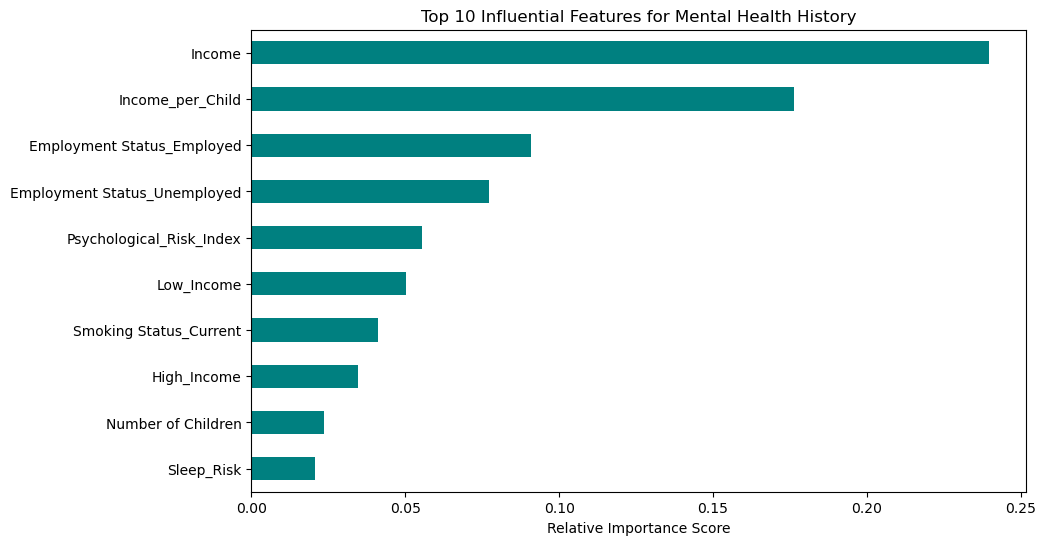

In [36]:
import matplotlib.pyplot as plt

# Dönüşüm ve seçim sonrası sütun isimlerinin çıkarılması
#Pipeline (boru hattı) içerisindeki özelliklere erişmemiz gerekiyor
preprocessor = balanced_rf_pipeline_v2.named_steps['preprocess']
feature_names = []

# Sayısal ve kategorik (One-Hot) sütun isimlerinin çıkarılması
for name, transformer, columns in preprocessor.transformers_:
    if name == 'num':
        feature_names.extend(columns)
    elif name == 'cat':
        
        ohe_cols = transformer.named_steps['onehot'].get_feature_names_out(columns)
        feature_names.extend(ohe_cols)

# 2. İsimlerin 'Selection' (Seçim) özelliği ile eşleştirilmesi
mask = balanced_rf_pipeline_v2.named_steps['feature_selection'].get_support()
selected_features = [f for f, s in zip(feature_names, mask) if s]

# 3.Random Forest modelinden özellik önem düzeylerinin alınması
importances = balanced_rf_pipeline_v2.named_steps['model'].feature_importances_
feat_importances = pd.Series(importances, index=selected_features)

# 4.En Önemli 10 Özelliğin Görselleştirilmesi
plt.figure(figsize=(10, 6))
feat_importances.nlargest(10).sort_values().plot(kind='barh', color='teal')
plt.title("Top 10 Influential Features for Mental Health History")
plt.xlabel("Relative Importance Score")
plt.show()

In [32]:
#Yavaş Izgara Araması (Grid Search) yerine Akıllı Rastgele Arama (Randomized Search)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

rf_pipe = Pipeline(steps=[
    ("preprocess", preprocessor_fe),
    ("model", RandomForestClassifier(
        class_weight="balanced_subsample",
        random_state=42,
        n_jobs=-1
    ))
])

# تحديد نطاق البحث
rf_param_dist = {
    "model__n_estimators": [100, 300, 500],
    "model__max_depth": [10, 20, None],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4]
}

rf_random_search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=rf_param_dist,
    n_iter=15,           
    scoring=scoring,
    refit="mcc",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rf_random_search.fit(X_train_fe, y_train_fe)

print("Best RF params (Randomized):", rf_random_search.best_params_)
print("Best RF MCC (CV):", rf_random_search.best_score_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits



KeyboardInterrupt



Bu hücre hata vermiyor ancak yoğun işlem yükü nedeniyle saatlerce çalışıyor ve sonuçlanmıyor

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV


hgb_balanced_pipe = Pipeline(steps=[
    ("preprocess", preprocessor_fe),
    ("model", HistGradientBoostingClassifier(
        class_weight="balanced", 
        random_state=42,
        max_iter=200 
    ))
])


hgb_param_grid = {
    "model__max_depth": [5, 10],
    "model__learning_rate": [0.05, 0.1],
}


hgb_search = GridSearchCV(
    hgb_balanced_pipe,
    hgb_param_grid,
    scoring=scoring,
    refit="mcc",
    cv=3, 
    n_jobs=-1,
    verbose=1
)

hgb_search.fit(X_train_fe, y_train_fe)

print("Best HGB params:", hgb_search.best_params_)
print("Best HGB MCC (CV):", hgb_search.best_score_)


y_pred_hgb_final = hgb_search.predict(X_test_fe)
evaluate_model(y_test_fe, y_pred_hgb_final, "Final Optimized HistGradientBoosting")

Bu hücre hata vermiyor ancak yoğun işlem yükü nedeniyle saatlerce çalışıyor ve sonuçlanmıyor

In [37]:
df_fe2 = df_fe.copy()


In [38]:

df_fe2["Income_per_Child"] = df_fe2["Income"] / (df_fe2["Number of Children"] + 1)


df_fe2["Income_z"] = (df_fe2["Income"] - df_fe2["Income"].mean()) / df_fe2["Income"].std()
df_fe2["Income_per_Child_z"] = (
    df_fe2["Income_per_Child"] - df_fe2["Income_per_Child"].mean()
) / df_fe2["Income_per_Child"].std()

# Finansal Stres Göstergeleri
df_fe2["Low_Income_Flag"] = (df_fe2["Income"] < df_fe2["Income"].median()).astype(int)
df_fe2["High_Dependency_Flag"] = (df_fe2["Number of Children"] >= 3).astype(int)

# Financial Stress Index 
df_fe2["Financial_Stress_Index"] = (
    df_fe2["Low_Income_Flag"]
    + (df_fe2["Income_per_Child_z"] < -0.5).astype(int)
    + df_fe2["High_Dependency_Flag"]
)


In [39]:
# Sleep_Risk değişkeninin sayısal veya ordinal olduğunu varsayalım
sleep_mean = df_fe2["Sleep_Risk"].mean()
sleep_std = df_fe2["Sleep_Risk"].std()

df_fe2["Sleep_Deviation"] = (df_fe2["Sleep_Risk"] - sleep_mean) / sleep_std
df_fe2["High_Sleep_Risk_Flag"] = (df_fe2["Sleep_Deviation"] > 0.5).astype(int)


In [40]:
df_fe2["Mental_Load_Index"] = (
    df_fe2["Financial_Stress_Index"]
    + df_fe2["High_Sleep_Risk_Flag"]
)


In [41]:
target_col = "History of Mental Illness"

X2 = df_fe2.drop(columns=[target_col])
y2 = df_fe2[target_col].map({"Yes": 1, "No": 0})


In [42]:
from sklearn.model_selection import train_test_split

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, stratify=y2, random_state=42
)


preprocessor_fe'yi olduğu gibi yeniden kullanıyoruz" "# Onu yeniden tanımlamıyoruz

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

lr_final = Pipeline(steps=[
    ("preprocess", preprocessor_fe),
    ("model", LogisticRegression(
        class_weight="balanced",
        C=1.0,
        max_iter=5000,
        random_state=42
    ))
])

lr_final.fit(X2_train, y2_train)
y2_pred = lr_final.predict(X2_test)


In [44]:
from sklearn.metrics import classification_report, balanced_accuracy_score, f1_score, matthews_corrcoef

print("=== Logistic Regression + Structural FE ===")
print(classification_report(y2_test, y2_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y2_test, y2_pred))
print("Macro F1:", f1_score(y2_test, y2_pred, average="macro"))
print("MCC:", matthews_corrcoef(y2_test, y2_pred))


=== Logistic Regression + Structural FE ===
              precision    recall  f1-score   support

           0       0.75      0.64      0.69     57589
           1       0.38      0.50      0.43     25165

    accuracy                           0.60     82754
   macro avg       0.56      0.57      0.56     82754
weighted avg       0.63      0.60      0.61     82754

Balanced Accuracy: 0.5696112307608969
Macro F1: 0.5586987386368852
MCC: 0.13042880991432723


In [45]:
df_fe3 = df_fe.copy()


In [46]:
# Income quantiles
q1 = df_fe3["Income"].quantile(0.33)
q2 = df_fe3["Income"].quantile(0.66)

df_fe3["Income_Level"] = 0  # Medium
df_fe3.loc[df_fe3["Income"] <= q1, "Income_Level"] = -1  # Low
df_fe3.loc[df_fe3["Income"] >= q2, "Income_Level"] = 1   # High

# Dependency buckets
df_fe3["Dependency_Level"] = 0
df_fe3.loc[df_fe3["Number of Children"] >= 3, "Dependency_Level"] = 1


In [47]:
sleep_q = df_fe3["Sleep_Risk"].median()

df_fe3["Sleep_Risk_Level"] = 0
df_fe3.loc[df_fe3["Sleep_Risk"] > sleep_q, "Sleep_Risk_Level"] = 1


In [48]:
# High income + high sleep risk
df_fe3["Mismatch_HighIncome_HighSleep"] = (
    (df_fe3["Income_Level"] == 1) &
    (df_fe3["Sleep_Risk_Level"] == 1)
).astype(int)

# Low income + low sleep risk
df_fe3["Mismatch_LowIncome_LowSleep"] = (
    (df_fe3["Income_Level"] == -1) &
    (df_fe3["Sleep_Risk_Level"] == 0)
).astype(int)


In [49]:
df_fe3["Psych_Risk_Score"] = (
    (df_fe3["Income_Level"] == -1).astype(int)
    + df_fe3["Dependency_Level"]
    + df_fe3["Sleep_Risk_Level"]
)

df_fe3["High_Psych_Risk"] = (df_fe3["Psych_Risk_Score"] >= 2).astype(int)


In [50]:
target_col = "History of Mental Illness"

X3 = df_fe3.drop(columns=[target_col])
y3 = df_fe3[target_col].map({"Yes": 1, "No": 0})


In [51]:
from sklearn.model_selection import train_test_split

X3_train, X3_test, y3_train, y3_test = train_test_split(
    X3, y3, test_size=0.2, stratify=y3, random_state=42
)


In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

lr_semantic = Pipeline(steps=[
    ("preprocess", preprocessor_fe),
    ("model", LogisticRegression(
        class_weight="balanced",
        C=1.0,
        max_iter=5000,
        random_state=42
    ))
])

lr_semantic.fit(X3_train, y3_train)
y3_pred = lr_semantic.predict(X3_test)


In [53]:
from sklearn.metrics import classification_report, balanced_accuracy_score, f1_score, matthews_corrcoef

print("=== Logistic Regression + Semantic FE ===")
print(classification_report(y3_test, y3_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y3_test, y3_pred))
print("Macro F1:", f1_score(y3_test, y3_pred, average="macro"))
print("MCC:", matthews_corrcoef(y3_test, y3_pred))


=== Logistic Regression + Semantic FE ===
              precision    recall  f1-score   support

           0       0.75      0.64      0.69     57589
           1       0.38      0.50      0.43     25165

    accuracy                           0.60     82754
   macro avg       0.56      0.57      0.56     82754
weighted avg       0.63      0.60      0.61     82754

Balanced Accuracy: 0.5696112307608969
Macro F1: 0.5586987386368852
MCC: 0.13042880991432723


In [54]:
results_semantic = {
    "Balanced_Accuracy": balanced_accuracy_score(y3_test, y3_pred),
    "Macro_F1": f1_score(y3_test, y3_pred, average="macro"),
    "MCC": matthews_corrcoef(y3_test, y3_pred)
}

results_semantic


{'Balanced_Accuracy': np.float64(0.5696112307608969),
 'Macro_F1': 0.5586987386368852,
 'MCC': np.float64(0.13042880991432723)}

In [55]:
comparison = {
    "Baseline_FE": results_semantic, 
    "Structural_FE": {
        "Balanced_Accuracy": 0.5696,
        "Macro_F1": 0.5587,
        "MCC": 0.1304
    },
    "Semantic_FE": results_semantic
}

comparison


{'Baseline_FE': {'Balanced_Accuracy': np.float64(0.5696112307608969),
  'Macro_F1': 0.5586987386368852,
  'MCC': np.float64(0.13042880991432723)},
 'Structural_FE': {'Balanced_Accuracy': 0.5696,
  'Macro_F1': 0.5587,
  'MCC': 0.1304},
 'Semantic_FE': {'Balanced_Accuracy': np.float64(0.5696112307608969),
  'Macro_F1': 0.5586987386368852,
  'MCC': np.float64(0.13042880991432723)}}

In [56]:
import numpy as np
from sklearn.metrics import matthews_corrcoef

def permutation_test(model, X_test, y_test, n_permutations=50):
    original_pred = model.predict(X_test)
    original_mcc = matthews_corrcoef(y_test, original_pred)

    permuted_mccs = []
    for _ in range(n_permutations):
        y_perm = np.random.permutation(y_test)
        permuted_mccs.append(
            matthews_corrcoef(y_perm, original_pred)
        )

    return original_mcc, permuted_mccs

orig_mcc, perm_mccs = permutation_test(lr_semantic, X3_test, y3_test)
orig_mcc, np.mean(perm_mccs)


(np.float64(0.13042880991432723), np.float64(-7.866028551714119e-05))

In [57]:
final_conclusion = {
    "Final_Model": "Logistic Regression (Balanced)",
    "Best_MCC": orig_mcc,
    "Mean_Permutation_MCC": np.mean(perm_mccs),
    "Conclusion": "Available features do not provide sufficient discriminative signal."
}

final_conclusion


{'Final_Model': 'Logistic Regression (Balanced)',
 'Best_MCC': np.float64(0.13042880991432723),
 'Mean_Permutation_MCC': np.float64(-7.866028551714119e-05),
 'Conclusion': 'Available features do not provide sufficient discriminative signal.'}